In [3]:
import json
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [8]:
BSM_SIZE = 18372145
N_FEATURES = 14

In [40]:
root_dir = 'MixAll_0024/'


# /VeReMi_82800_86400_2022-9-11_12:51:1
filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

# filenames = filenames[:10000]

attacker_sender_map = {}


for filepath in filenames:
    filename = filepath.split('/')[-1]
    _, vehicle, _, attacker = filename.split('-')[:4] # Rever definições da nomenclatura
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[vehicle_id] = attacker_type
             
bsm = np.memmap('bsm.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))
bsm_pos = 0
prev_receiver = None
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    receiver = int(filepath.split('/')[-1].split('-')[1])
    pbar.set_description("Vehicle ID {}".format(receiver))
    for line in f:
        data = json.loads(line)
        if data['type'] == 3:
            attack_type = attacker_sender_map.get(data['sender'], None)
            if attack_type is not None:
                out = (
                   data['messageID'],
                   data['rcvTime'],
                   data['sendTime'],
                   receiver,
                   data['sender'],
                   attack_type,
                   data['pos'][0],
                   data['pos'][1],
                   data['spd'][0],
                   data['spd'][1],
                   data['acl'][0],
                   data['acl'][1],
                   data['hed'][0],
                   data['hed'][1],
                )
                bsm[bsm_pos] = out
                bsm_pos += 1

  0%|          | 0/24677 [00:00<?, ?it/s]

In [41]:
bsm = np.memmap('bsm.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))

In [42]:
df = pd.DataFrame(bsm, columns=[
    'message_id',
    'rcv_time',
    'send_time',
    'receiver',
    'sender',
    'attack_type',
    'pos_x',
    'pos_y',
    'spd_x',
    'spd_y',
    'acl_x',
    'acl_y',
    'hed_x',
    'hed_y',
]).drop_duplicates(subset='message_id')#.set_index('message_id')
df = df[df.message_id != 0]
df = df.sort_values(['sender', 'send_time']).reset_index(drop=True)

df

,message_id,rcv_time,send_time,receiver,sender,attack_type,pos_x,pos_y,spd_x,spd_y,acl_x,acl_y,hed_x,hed_y
0,20224.0,539.952881,539.952881,27.0,21.0,0.0,512.986877,305.169678,-15.149040,-5.259165,-0.754126,-0.257891,-0.945767,0.324845
1,20612.0,556.952881,556.952881,27.0,21.0,0.0,265.189453,220.888367,-6.655805,-1.069099,4.449045,0.719840,-0.893505,0.449054
2,20640.0,557.952881,557.952881,27.0,21.0,0.0,257.854950,219.774048,-8.339111,-1.232982,-1.419570,-0.204918,-0.909672,0.415328
3,20668.0,558.952881,558.952881,27.0,21.0,0.0,248.314041,218.496826,-10.285843,-1.400385,-1.456526,-0.193267,-0.904841,0.425750
4,20776.0,563.952881,563.952881,27.0,21.0,0.0,176.377747,210.376114,-15.914332,-1.640642,-0.529833,-0.049563,-0.880145,0.474706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800868,437570880.0,86391.828125,86391.828125,147957.0,148065.0,0.0,865.453369,520.160583,-3.286072,2.044143,3.821068,-2.376868,-0.847506,0.530785
2800869,437571808.0,86392.828125,86392.828125,147957.0,148065.0,0.0,864.171692,521.022522,-0.703312,0.438220,-2.291596,1.427767,-0.847137,0.531375
2800870,437572576.0,86393.828125,86393.828125,147957.0,148065.0,0.0,862.619934,522.289856,-2.335815,1.611587,-1.393448,0.961477,-0.820392,0.571801
2800871,437573312.0,86394.828125,86394.828125,147957.0,148065.0,0.0,860.316650,525.306396,-3.295891,3.603786,-1.772204,1.937858,-0.671363,0.741129


In [43]:
# filter for prototyping
# df = df[:round(df.shape[0] * 0.1)]

split = round(df.shape[0] * 0.5)

train = df[:split]

filtered_train = train[train.attack_type < 10].drop(columns=['attack_type'])
filtered_train.to_csv('out_veremi/train.csv')

train = train.drop(columns=['attack_type'])
train.to_csv('out_veremi/train_no_filter.csv')

test = df[split:].drop(columns=['attack_type'])
test.to_csv('out_veremi/test.csv')

y = (df['attack_type'] >= 10)[split:].astype(int)

labels = pd.concat([y] * len(test.columns), ignore_index=True, axis=1)
labels.to_csv('out_veremi/labels.csv')

df_test_split = df[split:]

for i in range(10, 20):
    test_i = df_test_split[df_test_split.attack_type.isin((i, 0))].copy()
    
    y = (test_i.attack_type == i).astype(int)
    test_i.drop(columns=['attack_type'], inplace=True)
    
    labels_i = pd.concat([y] * len(test_i.columns), ignore_index=True, axis=1)

    test_i.to_csv(f'out_veremi/test_{i}.csv')
    labels_i.to_csv(f'out_veremi/labels_{i}.csv')

<Axes: >

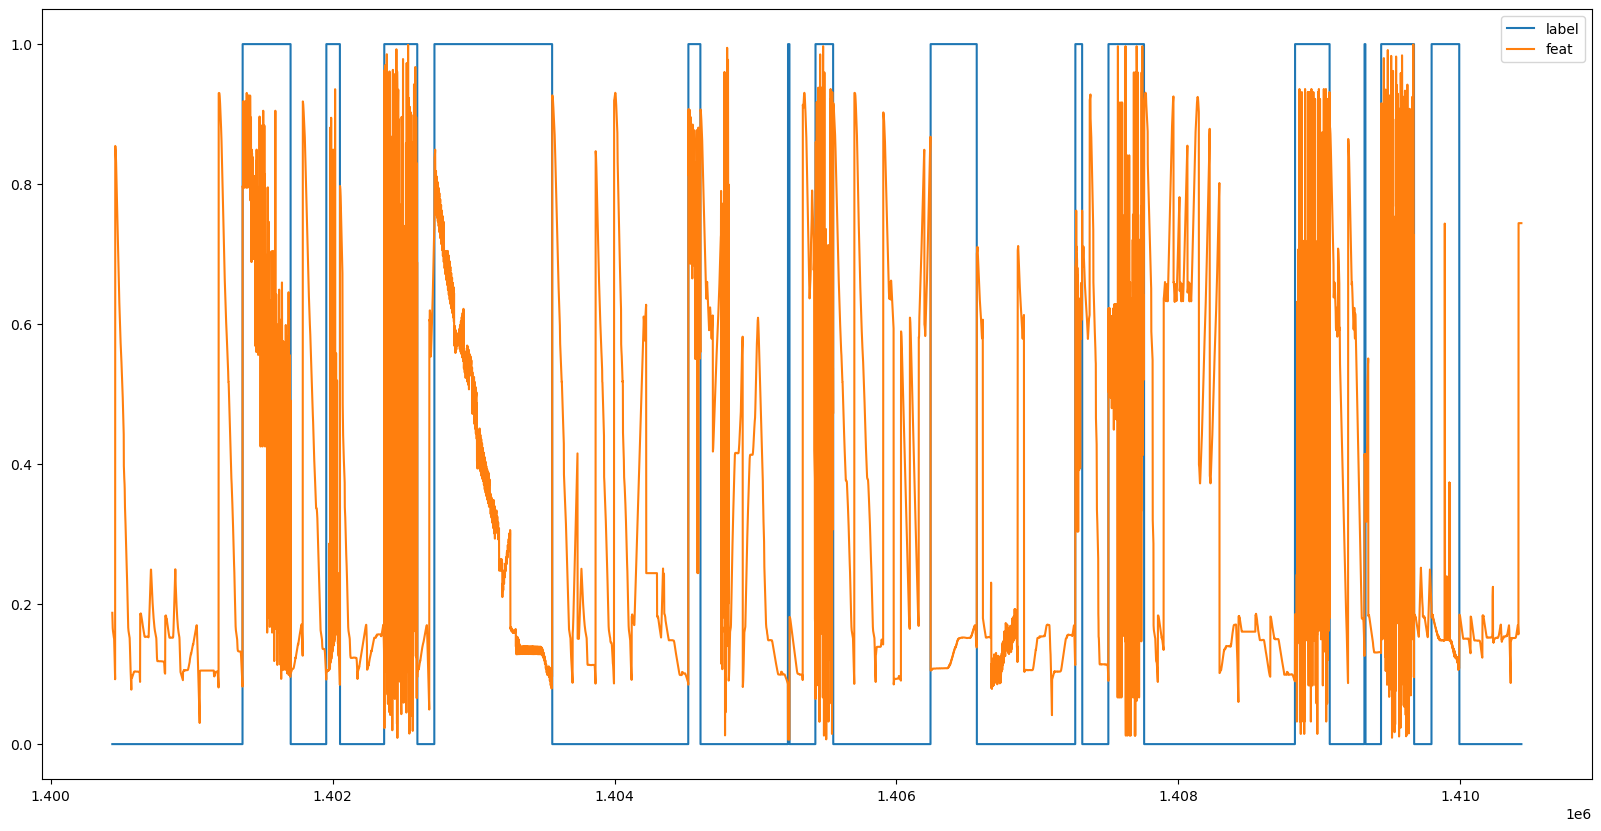

In [50]:
feat = test.pos_x

feat_norm = (feat - feat.min()) / (feat.max() - feat.min())

pd.DataFrame({ 'label': labels[0].head(10000), 'feat': feat_norm.head(10000) }).plot(figsize=(20,10))

In [ ]:
feat[feat.index ]